In [0]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime


from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error

In [0]:
pd.set_option('display.max_rows', 150)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 1000)

In [0]:
from google.colab import files

In [0]:
#Upload train data set file from local to colabs area
uploaded = files.upload()

Saving sales_dataset.csv to sales_dataset.csv


In [3]:
# Load Train dataset
train = pd.read_csv("sales_dataset.csv")
train.head(5).append(train.tail(5))

,Month,Sales
0,1984-01,2815
1,1984-02,2672
2,1984-03,2755
3,1984-04,2721
4,1984-05,2946
100,1992-05,4618
101,1992-06,5312
102,1992-07,4298
103,1992-08,1413
104,1992-09,5877


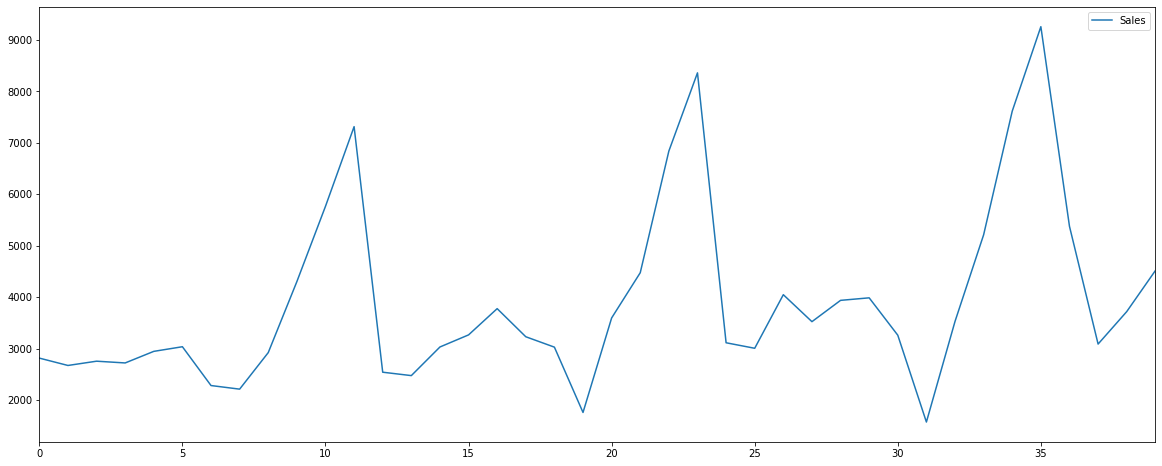

In [4]:
train[:40].plot(figsize=(20,8))

In [5]:
train.shape

(105, 2)

In [6]:
train.dtypes

Month    object
Sales     int64
dtype: object

In [0]:
train = train.set_index(['Month'])

In [0]:
train.index = pd.to_datetime(train.index)

In [9]:
train.dtypes

Sales    int64
dtype: object

In [0]:
from statsmodels.tsa.stattools import adfuller

In [0]:
#Stationary Control
#if P-Value is smaller than 0.005, we can say that there is stationary, else there is no stationary
#if our data has no stationary, I will plan to use differences

class Stationary:
    def __init__(self, significance=.005):
        self.SignificanceLevel = significance
        self.pValue = None
        self.isStationary = None

    def ADF_Stationarity_Test(self, timeseries, printResults=True):

        # Dickey-Fuller test:
        print(timeseries)
        try:
            adfTest = adfuller(timeseries, autolag='AIC')

            self.pValue = adfTest[1]

            if (self.pValue < self.SignificanceLevel):
                self.isStationary = True
            else:
                self.isStationary = False
            #self.isStationary=True
            if printResults:
                dfResults = pd.Series(adfTest[0:4],
                                      index=['ADF Test Statistic', 'P-Value', '# Lags Used', '# Observations Used'])

                # Add Critical Values
                for key, value in adfTest[4].items():
                    dfResults['Critical Value (%s)' % key] = value

                print('Augmented Dickey-Fuller Test Results:')
                print(dfResults)
        except Exception as e:
          print(e)
          self.isStationary = False

In [0]:
sTest = Stationary()

In [13]:
sTest.ADF_Stationarity_Test(train['Sales'])
print(sTest.isStationary)

Month
1984-01-01     2815
1984-02-01     2672
1984-03-01     2755
1984-04-01     2721
1984-05-01     2946
1984-06-01     3036
1984-07-01     2282
1984-08-01     2212
1984-09-01     2922
1984-10-01     4301
1984-11-01     5764
1984-12-01     7312
1985-01-01     2541
1985-02-01     2475
1985-03-01     3031
1985-04-01     3266
1985-05-01     3776
1985-06-01     3230
1985-07-01     3028
1985-08-01     1759
1985-09-01     3595
1985-10-01     4474
1985-11-01     6838
1985-12-01     8357
1986-01-01     3113
1986-02-01     3006
1986-03-01     4047
1986-04-01     3523
1986-05-01     3937
1986-06-01     3986
1986-07-01     3260
1986-08-01     1573
1986-09-01     3528
1986-10-01     5211
1986-11-01     7614
1986-12-01     9254
1987-01-01     5375
1987-02-01     3088
1987-03-01     3718
1987-04-01     4514
1987-05-01     4520
1987-06-01     4539
1987-07-01     3663
1987-08-01     1643
1987-09-01     4739
1987-10-01     5428
1987-11-01     8314
1987-12-01    10651
1988-01-01     3633
1988-02-01    

## **P-Values is higher than 0.005, so there no stationary.**

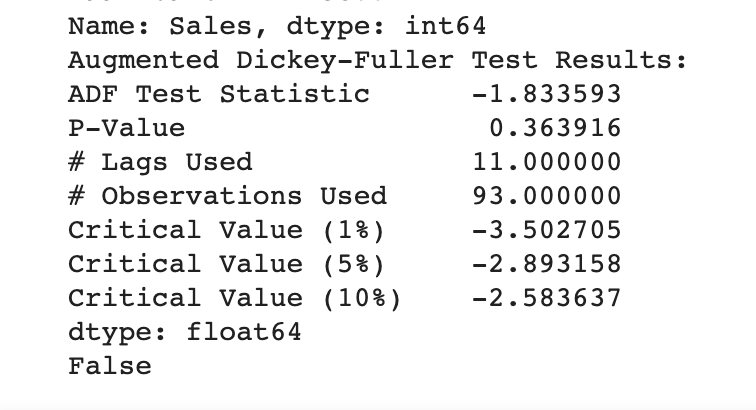

In [0]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        # print(interval, dataset[i], dataset[i - interval])
        diff.append(value)
    return pd.Series(diff)

In [0]:
diff_values = difference(train['Sales'], 1)

In [0]:
 # split train test
 xtrain, xtest = diff_values[0:-9], diff_values[-9:]

In [17]:
xtest

95    -8322
96     -784
97     1013
98      211
99     -170
100     694
101   -1014
102   -2885
103    4464
dtype: int64

In [0]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    dfx = pd.DataFrame(data)
    df = dfx.assign(**{
        '{} (t-{})'.format(col, t): dfx[col].shift(t)
        for t in range(lag+1)
        for col in dfx
    })

    df=df.drop([df.columns[0]], axis=1)
    df=df[df.columns[::-1]]
    return df[lag:]

In [0]:
from sklearn.preprocessing import MinMaxScaler

In [0]:
# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler()  # StandardScaler()  #

    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    tr_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    ts_scaled = scaler.transform(test)
    return scaler, tr_scaled, ts_scaled

In [0]:
values_unscaled = np.concatenate((xtrain, xtest))
supervised_raw = timeseries_to_supervised(values_unscaled, 12)

In [22]:
supervised_raw

,0 (t-12),0 (t-11),0 (t-10),0 (t-9),0 (t-8),0 (t-7),0 (t-6),0 (t-5),0 (t-4),0 (t-3),0 (t-2),0 (t-1),0 (t-0)
12,-143.0,83.0,-34.0,225.0,90.0,-754.0,-70.0,710.0,1379.0,1463.0,1548.0,-4771.0,-66
13,83.0,-34.0,225.0,90.0,-754.0,-70.0,710.0,1379.0,1463.0,1548.0,-4771.0,-66.0,556
14,-34.0,225.0,90.0,-754.0,-70.0,710.0,1379.0,1463.0,1548.0,-4771.0,-66.0,556.0,235
15,225.0,90.0,-754.0,-70.0,710.0,1379.0,1463.0,1548.0,-4771.0,-66.0,556.0,235.0,510
16,90.0,-754.0,-70.0,710.0,1379.0,1463.0,1548.0,-4771.0,-66.0,556.0,235.0,510.0,-546
17,-754.0,-70.0,710.0,1379.0,1463.0,1548.0,-4771.0,-66.0,556.0,235.0,510.0,-546.0,-202
18,-70.0,710.0,1379.0,1463.0,1548.0,-4771.0,-66.0,556.0,235.0,510.0,-546.0,-202.0,-1269
19,710.0,1379.0,1463.0,1548.0,-4771.0,-66.0,556.0,235.0,510.0,-546.0,-202.0,-1269.0,1836
20,1379.0,1463.0,1548.0,-4771.0,-66.0,556.0,235.0,510.0,-546.0,-202.0,-1269.0,1836.0,879
21,1463.0,1548.0,-4771.0,-66.0,556.0,235.0,510.0,-546.0,-202.0,-1269.0,1836.0,879.0,2364


In [0]:
supervised_raw = supervised_raw.values.astype("float32")

In [24]:
supervised_raw

array([[ -143.,    83.,   -34., ...,  1548., -4771.,   -66.],
       [   83.,   -34.,   225., ..., -4771.,   -66.,   556.],
       [  -34.,   225.,    90., ...,   -66.,   556.,   235.],
       ...,
       [ -241., -2974.,  4292., ...,  -170.,   694., -1014.],
       [-2974.,  4292.,  1030., ...,   694., -1014., -2885.],
       [ 4292.,  1030.,  2870., ..., -1014., -2885.,  4464.]],
      dtype=float32)

In [0]:
scaler, train_scaled, test_scaled = scale(xtrain.values.reshape(len(xtrain), 1), xtest.values.reshape(len(xtest), 1))

In [0]:
values_scaled = np.concatenate((train_scaled, test_scaled))

In [0]:
supervised = timeseries_to_supervised(values_scaled, 12)

supervised_values = supervised.values.astype('float32')

##split data into train and test-sets
supervised_train, supervised_test = supervised_raw[0:-9], supervised_raw[-9:]
train_scaled, test_scaled = supervised_values[0:-9], supervised_values[-9:]

In [0]:
train_X, train_y = train_scaled[:, :-1], train_scaled[:, -1]
test_X, test_y = test_scaled[:, :-1], test_scaled[:, -1]

In [0]:
# for lstm
train_X_lstm = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X_lstm = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

In [30]:
train_X

array([[0.71513903, 0.7296551 , 0.72214013, 0.7387758 , 0.7301047 ,
        0.6758944 , 0.7198279 , 0.76992744, 0.81289744, 0.81829274,
        0.82375234, 0.4178817 ],
       [0.7296551 , 0.72214013, 0.7387758 , 0.7301047 , 0.6758944 ,
        0.7198279 , 0.76992744, 0.81289744, 0.81829274, 0.82375234,
        0.4178817 , 0.7200848 ],
       [0.72214013, 0.7387758 , 0.7301047 , 0.6758944 , 0.7198279 ,
        0.76992744, 0.81289744, 0.81829274, 0.82375234, 0.4178817 ,
        0.7200848 , 0.760036  ],
       [0.7387758 , 0.7301047 , 0.6758944 , 0.7198279 , 0.76992744,
        0.81289744, 0.81829274, 0.82375234, 0.4178817 , 0.7200848 ,
        0.760036  , 0.7394181 ],
       [0.7301047 , 0.6758944 , 0.7198279 , 0.76992744, 0.81289744,
        0.81829274, 0.82375234, 0.4178817 , 0.7200848 , 0.760036  ,
        0.7394181 , 0.7570814 ],
       [0.6758944 , 0.7198279 , 0.76992744, 0.81289744, 0.81829274,
        0.82375234, 0.4178817 , 0.7200848 , 0.760036  , 0.7394181 ,
        0.7570814 ,

In [31]:
train_y

array([0.7200848 , 0.760036  , 0.7394181 , 0.7570814 , 0.6892543 ,
       0.7113495 , 0.6428158 , 0.84225065, 0.78078234, 0.8761642 ,
       0.82188964, 0.3875008 , 0.71745133, 0.79118764, 0.69066733,
       0.7509153 , 0.72747123, 0.67769283, 0.61596763, 0.84989405,
       0.8324234 , 0.87866914, 0.8296615 , 0.47517502, 0.57742953,
       0.764789  , 0.77545124, 0.72470933, 0.72554433, 0.66805834,
       0.594579  , 0.9231807 , 0.7685786 , 0.90969235, 0.87442994,
       0.27355644, 0.7666517 , 0.7154602 , 0.7222044 , 0.75810903,
       0.7311324 , 0.6737106 , 0.5803199 , 0.9378894 , 0.8446914 ,
       0.91290385, 0.81893504, 0.25448006, 0.7205344 , 0.7598433 ,
       0.7092941 , 0.7687713 , 0.705633  , 0.65020233, 0.6150042 ,
       0.9427709 , 0.8303038 , 0.9768129 , 0.9242726 , 0.        ,
       0.74102384, 0.7545764 , 0.74808913, 0.67210484, 0.79234374,
       0.73916113, 0.56509733, 0.94803774, 0.8015929 , 0.9438628 ,
       0.93204445, 0.13713148, 0.6747383 , 0.79651874, 0.74937

In [0]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

In [33]:
# Training
now = datetime.now()
print("Process started at : ",now)

parameters = { 'gamma' : [0, 0.1, 0.3, 1], 'learning_rate' : [0.0001, 0.001, 0.01, 0.1], 
              'max_depth' : [3, 4, 5, 6, 7, 9, 12], 
              'n_estimators' : [50, 90, 100, 150, 200, 250, 300, 350, 400],
              'nthread' : [-1], 'reg_alpha' : [1], 'reg_lambda' : [1], 'seed' : [10] }
"""
parameters = { 'gamma' : [0, 0.01, 0.02, 0.03], 'learning_rate' : [0.2, 0.3, 0.5, 0.1], 
              'max_depth' : [1, 2, 3, 4, 5, 6], 'booster' : ['gbtree', 'gblinear', 'dart'],
              'n_estimators' : [90, 100, 110, 120, 130, 140, 150, 200],
              'nthread' : [-1], 'reg_alpha' : [1], 'reg_lambda' : [1], 'seed' : [10] }
"""
bst = xgb.XGBRegressor()
xgb_grid = GridSearchCV(bst,
                        parameters,
                        cv=10,
                        n_jobs=-1,
                        verbose=True,
                        )
xgb_grid.fit(train_X, train_y, eval_set=[(train_X, train_y)], early_stopping_rounds=50)

end = datetime.now()
print("Process finished at : ", end)
print("Process took : ", end-now)

Process started at :  2020-03-14 11:22:34.461682
Fitting 10 folds for each of 1008 candidates, totalling 10080 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   33.6s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 2446 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 3196 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 4046 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done 4996 tasks      | elapsed: 12.9min
[Parallel(n_jobs=-1)]: Done 6046 tasks      | elapsed: 15.8min
[Parallel(n_jobs=-1)]: Done 7196 tasks      | elapsed: 18.8min
[Parallel(n_jobs=-1)]: Done 8446 tasks      | elapsed: 21.9min
[Parallel(n_jobs=-1)]: Done 9796 tasks      | elapsed: 25.4min


[11:48:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.266069
Will train until validation_0-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:0.245715
[2]	validation_0-rmse:0.227706
[3]	validation_0-rmse:0.211711
[4]	validation_0-rmse:0.197593
[5]	validation_0-rmse:0.184954
[6]	validation_0-rmse:0.173873
[7]	validation_0-rmse:0.162972
[8]	validation_0-rmse:0.153919
[9]	validation_0-rmse:0.145328
[10]	validation_0-rmse:0.138294
[11]	validation_0-rmse:0.131229
[12]	validation_0-rmse:0.125479
[13]	validation_0-rmse:0.120407
[14]	validation_0-rmse:0.115917
[15]	validation_0-rmse:0.11134
[16]	validation_0-rmse:0.107862
[17]	validation_0-rmse:0.104284
[18]	validation_0-rmse:0.101254
[19]	validation_0-rmse:0.098777
[20]	validation_0-rmse:0.096149
[21]	validation_0-rmse:0.09389
[22]	validation_0-rmse:0.09199
[23]	validation_0-rmse:0.089686
[24]	validation_0-rmse:0.087983
[25]	validation_0-rms

[Parallel(n_jobs=-1)]: Done 10080 out of 10080 | elapsed: 25.9min finished


[48]	validation_0-rmse:0.071798
[49]	validation_0-rmse:0.071678
[50]	validation_0-rmse:0.071516
[51]	validation_0-rmse:0.071193
[52]	validation_0-rmse:0.071104
[53]	validation_0-rmse:0.070819
[54]	validation_0-rmse:0.07068
[55]	validation_0-rmse:0.07058
[56]	validation_0-rmse:0.070517
[57]	validation_0-rmse:0.070275
[58]	validation_0-rmse:0.070191
[59]	validation_0-rmse:0.070141
[60]	validation_0-rmse:0.069933
[61]	validation_0-rmse:0.069875
[62]	validation_0-rmse:0.069685
[63]	validation_0-rmse:0.06964
[64]	validation_0-rmse:0.069408
[65]	validation_0-rmse:0.069375
[66]	validation_0-rmse:0.069346
[67]	validation_0-rmse:0.069112
[68]	validation_0-rmse:0.068976
[69]	validation_0-rmse:0.068852
[70]	validation_0-rmse:0.068831
[71]	validation_0-rmse:0.06881
[72]	validation_0-rmse:0.0687
[73]	validation_0-rmse:0.068683
[74]	validation_0-rmse:0.068668
[75]	validation_0-rmse:0.068568
[76]	validation_0-rmse:0.068556
[77]	validation_0-rmse:0.068546
[78]	validation_0-rmse:0.068415
[79]	validatio

In [34]:
xgb_grid.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=4, min_child_weight=1, missing=None, n_estimators=90,
             n_jobs=1, nthread=-1, objective='reg:linear', random_state=0,
             reg_alpha=1, reg_lambda=1, scale_pos_weight=1, seed=10,
             silent=None, subsample=1, verbosity=1)

In [0]:
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))

    inverted = scaler.inverse_transform(array)
    ##print("converting %s to %s" % (value,inverted[0, -1]))
    return inverted[0, -1]

In [0]:
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

In [0]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [0]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((np.array(y_true) - np.array(y_pred)) / y_true)) * 100

In [0]:
predictions = list()
start = 9 # test period
l = len(test_scaled) - start

rmse = []
mape = []

# test periodu kadar dönecek. 
for i in range(len(test_scaled)):
    X1, y = test_scaled[l, 0:-1], test_scaled[l, -1]
    X1 = X1[-12:] # ts_window

    # prediction 
    # pred = predict()
    X1 = X1.reshape((1,-1))
    pred = xgb_grid.predict(X1)

    yhat = invert_scale(scaler, X1[0], pred)
        
    l=l+1

    yhat = inverse_difference(train['Sales'], yhat, len(test_scaled) + 1 - i) # if not stationary 

    predictions.append(yhat)

    rmse.append(sqrt(mean_squared_error([train['Sales'][-9:][i]], [yhat])))
    mape.append(mean_absolute_percentage_error([train['Sales'][-9:][i]], [yhat]))

In [41]:
print("Test RMSE:", np.mean(rmse))
print("Test MAPE:", np.mean(mape))

Test RMSE: 1462.1064494782024
Test MAPE: 32.91011694404179


In [42]:
predictions

[8773.90181595087,
 4429.887395739554,
 3956.8049623966203,
 5410.161548972129,
 5376.715527415275,
 5070.442828059196,
 6255.903532862662,
 1685.3278757333746,
 2482.6918609142294]

In [0]:
result_df = pd.read_csv("sales_dataset.csv")

In [0]:
result_df = result_df[-9:]

In [45]:
result_df.head(9)

,Month,Sales
96,1992-01,4348
97,1992-02,3564
98,1992-03,4577
99,1992-04,4788
100,1992-05,4618
101,1992-06,5312
102,1992-07,4298
103,1992-08,1413
104,1992-09,5877


In [46]:
result_df['XGB_Predictions'] = predictions
result_df.head(9)

,Month,Sales,XGB_Predictions
96,1992-01,4348,8773.901816
97,1992-02,3564,4429.887396
98,1992-03,4577,3956.804962
99,1992-04,4788,5410.161549
100,1992-05,4618,5376.715527
101,1992-06,5312,5070.442828
102,1992-07,4298,6255.903533
103,1992-08,1413,1685.327876
104,1992-09,5877,2482.691861


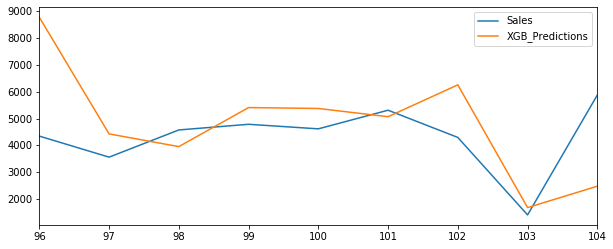

In [47]:
result_df[:9].plot(figsize=(10,4))

In [0]:
#Export dataframe as a csv
result_df.to_csv("results.csv", index=0)

In [54]:
train.head(5).append(train.tail(5))

,Sales
Month,
1984-01-01,2815
1984-02-01,2672
1984-03-01,2755
1984-04-01,2721
1984-05-01,2946
1992-05-01,4618
1992-06-01,5312
1992-07-01,4298
1992-08-01,1413


# **AutoArima**

In [0]:
arima_parameters = {
    'start_p' : '1', 'start_q' : '1', 'start_d' : '1',
    'start_P' : '1', 'start_Q' : '1', 'D' : '1', 'm' : '7',
    'max_P' : '10', 'max_Q' : '10', 'max_D' : '10', 'max_d' : '10',
    'max_order' : '21', 'max_p' : '10', 'max_q' : '10', 'seasonal' : 'true',
    'stepwise' : 'true', 'error_action' : 'ignore',
    'information_criterion' : 'aic', 'suppress_warnings' : 'true',
    'trace' : 'true', 'trend' : 'ct'}

In [51]:
pip install pyramid-arima

     |████████████████████████████████| 604kB 2.8MB/s 


In [52]:
from pyramid.arima import auto_arima

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/pyramid/__init__.py:68: UserWarning: 
    The 'pyramid' package will be migrating to a new namespace beginning in 
    version 1.0.0: 'pmdarima'. This is due to a package name collision 

In [88]:
train[:-9].head(5)

,Sales
Month,
1984-01-01,2815
1984-02-01,2672
1984-03-01,2755
1984-04-01,2721
1984-05-01,2946


In [62]:
!pip install chart_studio

In [0]:
import chart_studio.plotly as plot_mpl
import plotly.graph_objs as go

from socket import socket

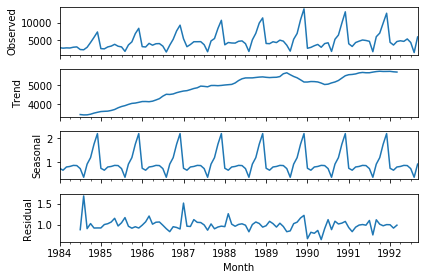

In [67]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(train, model='multiplicative')
fig = result.plot()

In [0]:
arima_train = train[:-9]
arima_test = train[-9:]

(data, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

In [242]:
# Arima Training
now = datetime.now()
print("Arima process started at : ",now)

arima_stepwise_model = auto_arima(train, start_p=0, start_q=0,
                           max_p=13, max_q=13, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True,
                           n_jobs=4)#n_jobs for parallel process
end = datetime.now()
print("Arima process finished at : ", end)
print("Process took : ", end-now)

print(arima_stepwise_model)

Arima process started at :  2020-03-14 14:04:35.930708


/usr/local/lib/python3.6/dist-packages/pyramid/arima/auto.py:379: UserWarning:

stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.



Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 1, 12); AIC=1520.049, BIC=1527.614, Fit time=0.427 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=1526.661, BIC=1531.705, Fit time=0.021 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=1509.055, BIC=1519.143, Fit time=0.569 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=1490.560, BIC=1500.647, Fit time=0.942 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=1492.021, BIC=1504.630, Fit time=1.277 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=1491.820, BIC=1499.385, Fit time=0.146 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=1492.046, BIC=1504.655, Fit time=3.981 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=1490.662, BIC=1505.792, Fit time=4.424 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=1485.184, BIC=1497.793, Fit time=1.780 seconds
Fit ARIMA: order=(1, 1, 0) s

In [0]:
arima_predicts = arima_stepwise_model.fit(arima_train)

In [0]:
future_forecast = arima_predicts.predict(n_periods=9)

In [245]:
future_forecast

array([3580.72257032, 3091.80076194, 4095.4525918 , 4454.95797763,
       4605.29974041, 4651.2457211 , 4440.99372435, 1587.02820175,
       5696.16813252])

In [0]:
arima_rmse = sqrt(mean_squared_error(train['Sales'][-9:], future_forecast))

In [0]:
arima_mape = mean_absolute_percentage_error(train['Sales'][-9:], future_forecast)

In [248]:
print("Test RMSE:", np.mean(arima_rmse))
print("Test MAPE:", np.mean(arima_mape))

Test RMSE: 431.36506422601934
Test MAPE: 8.867407129635856


In [249]:
result_df['Arima_Predictions'] = future_forecast
result_df.head(9)

,Month,Sales,XGB_Predictions,Arima_Predictions
96,1992-01,4348,8773.901816,3580.722570
97,1992-02,3564,4429.887396,3091.800762
98,1992-03,4577,3956.804962,4095.452592
99,1992-04,4788,5410.161549,4454.957978
100,1992-05,4618,5376.715527,4605.299740
101,1992-06,5312,5070.442828,4651.245721
102,1992-07,4298,6255.903533,4440.993724
103,1992-08,1413,1685.327876,1587.028202
104,1992-09,5877,2482.691861,5696.168133


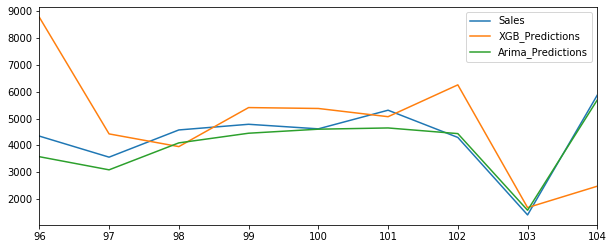

In [250]:
result_df[:9].plot(figsize=(10,4))

In [0]:
#Export dataframe as a csv
result_df.to_csv("results.csv", index=0)